# RA Diagnosis Extraction with Machine Learning
This notebook is built for extracting the diagnosis from format-free textfields of Electronic Medical Health records. 
- Feel free to make some adjustments that better correspond with your data

In [1]:
SEED = 26062019

test_size = 0.5 

import sys
sys.path.append('/exports/reum/tdmaarseveen/modules')
from scipy import __version__ as sc_vers
from yellowbrick import __version__ as yb_vers
from sklearn import __version__ as sk_vers
import buildingAClassifier as bc
from pattern import __version__ as pat_vers
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from sklearn import datasets, svm, model_selection, tree, preprocessing, metrics
import sklearn.ensemble as ske
from matplotlib import __version__ as m_vers
import re
import random
import pickle
import xgboost as xgb

print('Current versions Modules:\n')
print('Pandas version:\t\t' + pd.__version__)
print('Matplotlib version:\t' + m_vers)
print('numpy version:\t\t' + np.__version__)
print('sklearn version:\t' + sk_vers)
print('scipy version:\t\t' + sc_vers)
print('pattern version:\t' + pat_vers)
print('yellowbrick version:\t' + yb_vers)
print('xgb version:\t' + xgb.__version__)

Current versions Modules:

Pandas version:		0.23.0
Matplotlib version:	2.2.2
numpy version:		1.17.0
sklearn version:	0.21.2
scipy version:		1.1.0
pattern version:	3.6
yellowbrick version:	0.9.1
xgb version:	0.90


## Step 1: Cleaning Data
### 1.1 Preprocessing - Word segmentation and lemmatizing 
Applying Natural Language Processing algorithms:
- Word segmentation: words are split on whitespace -> special characters are removed
- lemmatization: words are returned to the root form (if word is in corpus)

In [42]:
radiag_df = pd.read_csv(r'data/2000patients_TrainingSet_1RandomEntry05082019.csv', sep='|')
radiag_df.head()

,Datum,FIRSTVISIT,ID,PATNR,PEC,XANTWOORD,Outcome,pt level conclusie
0,2018-07-18 00:00:00+00:00,2018-07-02 00:00:00+00:00,113807326,40930,2018-07-02 00:00:00+00:00,chronische pijn en vermoiedheid non-inflammat...,n,n
1,2013-05-09 00:00:00+00:00,2013-02-13 00:00:00+00:00,111053368,49745,2013-02-13 00:00:00+00:00,vooralsnog geen aanwijzingen onderliggende inf...,n,n
2,2013-12-12 00:00:00+00:00,2013-11-21 00:00:00+00:00,111376312,71845,2013-11-21 00:00:00+00:00,1 primaire handartrose ( beginnend en minimaal...,n,n
3,2013-10-01 00:00:00+00:00,2013-09-16 00:00:00+00:00,111282651,78674,2013-09-16 00:00:00+00:00,nu geen aanwijzingen onderliggende inflammatoi...,n,n
4,2011-09-02 00:00:00+00:00,2011-07-08 00:00:00+00:00,110314254,127561,2011-07-08 00:00:00+00:00,pijnklachten pols bij artrose met zwelling van...,n,NaN


In [43]:
import time

radiag_df['XANTWOORD'] = radiag_df['XANTWOORD'].apply(lambda x : bc.processArtefactsXML(str(x)))
radiag_df['XANTWOORD'] = radiag_df['XANTWOORD'].apply(lambda x : bc.simpleCleaning(x, lemma=False))

typocor = bc.TypoCorrection(np.array(l_new)) # provide word list
t0 = time.time()
radiag_df['XANTWOORD'] = radiag_df['XANTWOORD'].apply(lambda x : typocor.correct(x))
t1 = time.time()
print('Time for TypoCorrection (n=' + str(len(radiag_df)) + ') : ' + str(t1-t0))
radiag_df['XANTWOORD'] = radiag_df['XANTWOORD'].apply(lambda x : bc.lemmatizingText(x))

# Save autocorrected dataframe
radiag_df.to_csv(r'data/autocorrect_2000patientsrandom.csv', sep='|', index=False)

Time for TypoCorrection (n=1998) : 6.127357482910156e-05


### 1.2 Balancing classes in data (Proportion RA cases vs. non cases) - Optional
The number of non-cases is larger than nr. of cases so a random sample of non cases is selected to create a balance between the classes. 
- Optional: Whether or not you want to balance the classes depends on the expected prevalence of the cases in the test data. 
- You could also choose to balance the classes in a different way (eg: 1:5) but it should always correspond with the expected prevalence in the test set. Choose the desired nr of samples by changing nr_of_samples

In [44]:
balance = False
nr_of_samples = len(radiag_df[radiag_df['Outcome']=='y'])

if (balance):
    df_no_outcome = radiag_df[radiag_df['Outcome']=='n'].sample(n=nr_of_samples, random_state=SEED)
    equal_radiag_df = pd.concat([df_no_outcome, radiag_df[radiag_df['Outcome']=='y']])
    radiag_df = equal_radiag_df.sample(frac=1, random_state=SEED)

### 1.3 Splitting annotated set on both the textual data and the label (Y)

In [45]:
X = radiag_df['XANTWOORD'].values
y = radiag_df['Outcome'].values
y_b = np.array([bc.binarize(val) for val in y])

### 1.4 Visualizing the data
#### Plot: Prevalence of RA-cases
Positive control -> classes should be in balance

(1881, 117)


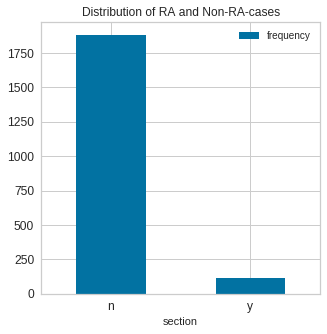

In [46]:
from collections import Counter

labels, values = zip(*Counter(y).items())
print(values)
df = pd.DataFrame({'section':labels, 'frequency':values})
ax = df.plot(kind='bar',  title ="Distribution of RA and Non-RA-cases", figsize=(5, 5), x='section', legend=True, fontsize=12, rot=0)

#### Plot: Lexical Dispersion Plot
- Showcases the prevalence of features
- The feature’s homogeneity across the entries

/home/tdmaarseveen/.conda/envs/ml_env/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  after removing the cwd from sys.path.


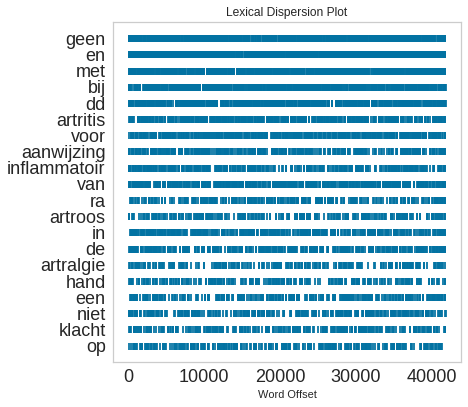

In [47]:
import importlib
importlib.reload(bc)

bc.plotLexicalDispersion(X, nr_features=20, ngram_range=(1,1))

#### Plot: Feature distribution

<module 'matplotlib.pyplot' from '/home/tdmaarseveen/.conda/envs/ml_env/lib/python3.5/site-packages/matplotlib/pyplot.py'>

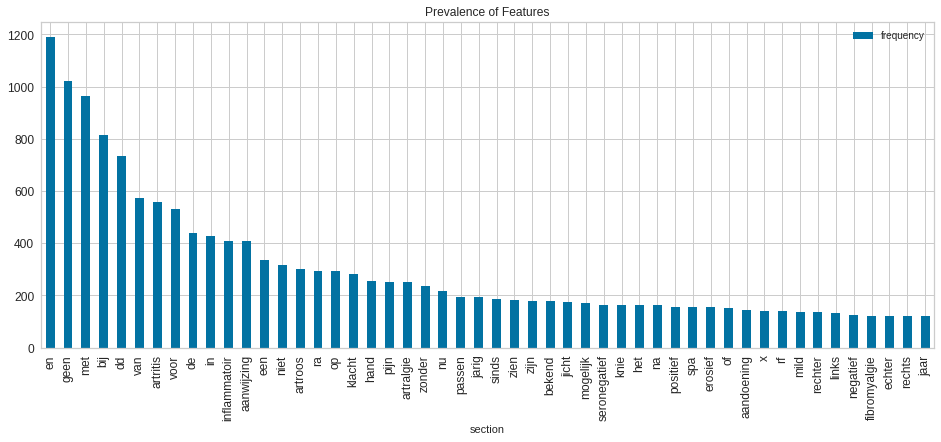

In [48]:
bc.plotSampleDistribution(X, nr_features=50) 

## Step 2: Building the Pipeline

First: Import important modules

In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier

### 2.1 Import different classification models:
Listed below are the following models: Naive Bayes, Gradient Boosting, Neural Networks, Decision tree & SVM.

In [17]:
SEED=777
import sklearn.ensemble as ske
pipe_list = [
    # Naive Bayes - 0
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', MultinomialNB()),
            ]),
    # Gradient Boosting - 1
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', ske.GradientBoostingClassifier(random_state=SEED))
            ]),
    # Neural Networks - 2
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', MLPClassifier(solver='lbfgs', random_state=SEED)), # hidden_layer_sizes=(5, 2), , 
            ]),
    # Decision Tree - 3
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', tree.DecisionTreeClassifier(random_state=SEED)),
            ]),
    # XGB classifier 4
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', XGBClassifier(random_state=SEED)), # learning_rate=0.1,n_estimators=100, 
            ]),
    # SVM 5 - NuSVC probability
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', SGDClassifier(loss='log', random_state=SEED)),
            ]),
    # Random Forest 6
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', RandomForestClassifier(random_state=SEED)), # n_estimators=100, max_depth=2,
            ]),
    # Dummy 7
    Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', DummyClassifier(random_state=SEED)),
            ]),
    ]

### 2.2 Initialize the Word Matching Method
The word matching method classifies based on the presence of the provided targets.

The following targets are provided: 'rheumatoid arthritis', 'reumatoide artritis' and 'ra'. 

In [18]:
l_targets = ['rheumatoid arthritis', 'reumatoide artritis', 'ra']
WordMatching = bc.CustomBinaryModel(l_targets)

## Step 3: Compare classification models
Visualize performance of the models in ROC curve

- Note: the ROC curve of the decision tree estimator cant be assessed with the standard plotCrossValidationROC function, because it doesn't calculate the probabilities. Therefore, the function plotBinaryROC is utilized to estimate the decision tree ROC. 

Word Matching 0.9080227190339112 (std : +/-0.01708000725361631 )
Decision Tree 0.8545148328413881 (std : +/-0.018834633448664383 )
Train-score Decision Tree 0.9942000651678071 (std : +/-0.002249761282289655 )
Naive Bayes 0.8171370853480671 (std : +/-0.02439566311899585 )
Train-score Naive Bayes 0.9836672165272706 (std : +/-0.007165149082764275 )
Gradient Boosting 0.97062787379275 (std : +/-0.009574262413000257 )
Train-score Gradient Boosting 0.9947862813695764 (std : +/-0.00032873313139662584 )
Neural Networks 0.9657066673801149 (std : +/-0.008288005826405797 )
Train-score Neural Networks 0.9949415022608837 (std : +/-4.842704931434842e-05 )
XGBoost 0.9747969470074915 (std : +/-0.005929709997931613 )
Train-score XGBoost 0.9929689586218049 (std : +/-0.0030182319222988793 )
SVM 0.9669285488409185 (std : +/-0.0093524264530931 )
Train-score SVM 0.9948067293503662 (std : +/-0.00028225133257174165 )
Random Forest 0.8934783021135468 (std : +/-0.039185224900331425 )
Train-score Random Forest 0.

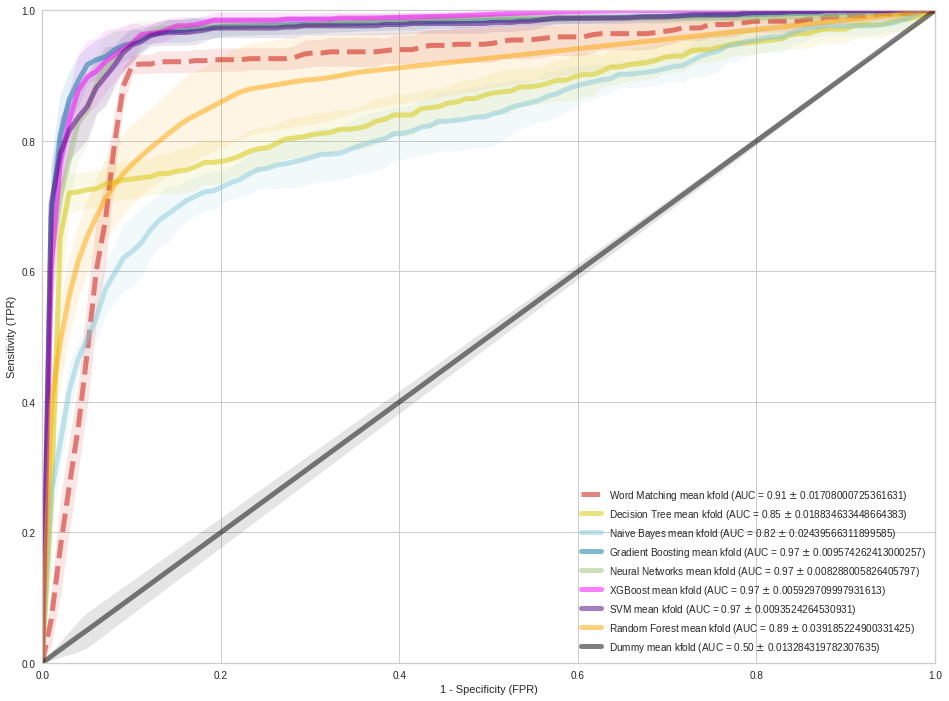

In [58]:
lbls = ['Naive Bayes', 'Gradient Boosting', 'Neural Networks', 'XGBoost', 'SVM', 'Random Forest', 'Dummy'] #  

l_folds = bc.preset_CV10Folds(X)
filtered_pipe = pipe_list[:3] + pipe_list[4:8] # exclude decision -> because it cant assess the probabilities!
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(16,12))

plt, ref_auc, auc_ref, fitted_wm = bc.plotCustomModelROC(WordMatching, X, y, l_folds, 'Word Matching', 'r', '--') # custom made roc
plt, dt_auc, auc_dt, fitted_dt = bc.plotBinaryROC(pipe_list[3], 'Decision Tree', X, y, l_folds, 'y')
plt, d_aucs, fitted_models = bc.plotCrossValidationROC(filtered_pipe,'ROC curve for different classification methods', lbls, X, y, l_folds, ref_auc)
plt.savefig('figures/ROC_curve_all_methods.png', bbox_inches='tight')

### 3.1. Student's T-Test relative to Naive Word Matching

auc_ref = ROC- Area under the curve of the naaive Word Matching method
d_aucs = dictionary with all of the aucs 

In [59]:
import scipy

for key in d_aucs.keys(): # classifiers with probabilities
    twosample_results = scipy.stats.ttest_ind(d_aucs[key], auc_ref)
    print(key, '\t(p =', str(twosample_results[1]), ')')

# classifiers without probabilities
print('Decision Tree\t(p =', scipy.stats.ttest_ind(auc_dt, auc_ref)[1], ')')

XGBoost 	(p = 1.2945970819854114e-09 )
Random Forest 	(p = 0.3546182893280472 )
Neural Networks 	(p = 2.2206148024795293e-08 )
Dummy 	(p = 9.83200910488686e-22 )
Naive Bayes 	(p = 3.6272605859110254e-08 )
SVM 	(p = 2.204588526271861e-08 )
Gradient Boosting 	(p = 1.1356612870546318e-08 )
Decision Tree	(p = 6.573472078117586e-06 )


### 3.2. AUC - Precision Recall curve

Word Matching 0.3568844739005081 (std : +/-0.02403020491376081 )
Decision Tree 0.5168947640703205 (std : +/-0.04136685277638155 )
Naive Bayes 0.43738967966245024 (std : +/-0.03080044933175996 )
Gradient Boosting 0.824807041461495 (std : +/-0.03771924026643456 )
Neural Networks 0.7958915478830233 (std : +/-0.03971753863212068 )
XGBoost 0.792025684107514 (std : +/-0.02999728283665548 )
SVM 0.829407659963733 (std : +/-0.035225170029257784 )


/home/tdmaarseveen/.conda/envs/ml_env/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest 0.603710882536166 (std : +/-0.05763507108811722 )
Dummy 0.09340266170527517 (std : +/-0.032405766735326386 )


<module 'matplotlib.pyplot' from '/home/tdmaarseveen/.conda/envs/ml_env/lib/python3.5/site-packages/matplotlib/pyplot.py'>

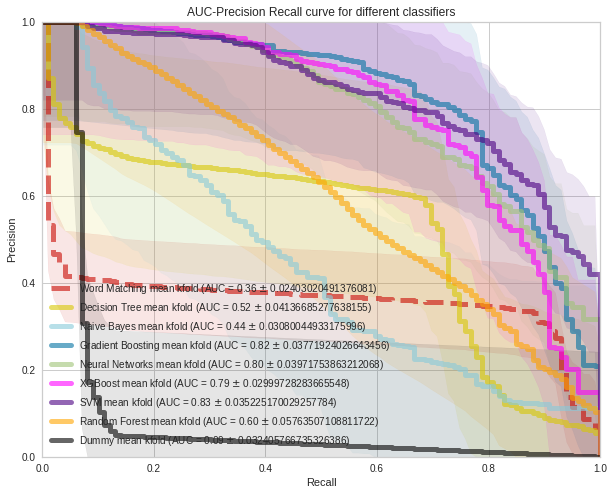

In [50]:
import matplotlib.pyplot as plt
import importlib
importlib.reload(bc)
plt.figure(figsize=(10,8))

l_folds = bc.preset_CV10Folds(X)
filtered_pipe = pipe_list[:3] + pipe_list[4:8]
lbls = ['Naive Bayes', 'Gradient Boosting', 'Neural Networks', 'XGBoost', 'SVM', 'Random Forest', 'Dummy'] #  

colors = ['c', 'b', 'g', 'magenta', 'indigo', 'orange', 'black']
prev = 0.5
title = 'AUC-Precision Recall curve for different classifiers'
bc.plotCustomModelPR(WordMatching, X, y, l_folds, 'Word Matching', 'r', '--') # Approximation (sorted)
bc.plotBinaryPR(pipe_list[3], X, y, l_folds, 'Decision Tree', 'y') # Approximation (sorted)
bc.plotCrossValidationPR(filtered_pipe, X, y_b, l_folds, title, lbls, colors)


## Step 4: Distribute Model - save best classification model

In [61]:
best_model = fitted_models['Gradient Boosting'] # median iteration
filename='savedModels/GradientBoosting.sav'
pickle.dump(best_model[2], open(filename, 'wb'))

### 4.1 Import best performing model

In [62]:
filename='savedModels/GradientBoosting.sav'
loaded_model = pickle.load(open(filename, 'rb'))

## Step 5: Evaluate best Model
Determine cut-off

In [71]:
gbm_model = fitted_models['Gradient Boosting']

# Import the fitted model + fold information + the optimal cut_off
estimator = gbm_model[2] # the entire pipeline
classifier = estimator.steps[1] # only the classifier
test_index = gbm_model[3] # use this to get the test set of the k-fold
train_index = gbm_model[4] # use this to get the trainingset of the k-fold
cut_off = gbm_model[5]
# Apply the cut-off on the probabilities -> to assess the predictions
l_pred = [int(gbm_model[0][i] >= cut_off) for i in range(len(gbm_model[0]))]

### 5.1 Scatterplot visualizing the classification capabilities (probabilities)

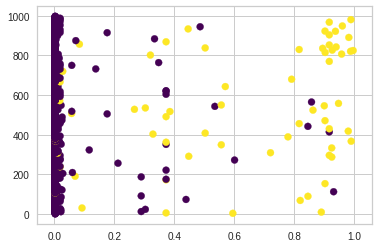

In [64]:
ax = plt.scatter(x=gbm_model[0], y=list(range(len(gbm_model[0]))), c=y_b[test_index], cmap='viridis')

### 5.2 Evaluate Performance on lower prevalence of RA-cases
#### 5.2.1 Sensitivity & specificity should not be affected by changing the prevalence of cases

In [ ]:
plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 10})
plt, mean_auc = bc.classifyOnLowerPrevalence(filtered_pipe[1], X, np.array(y_b), 1, 'GBM 50/50', 'g')
plt, mean_auc = bc.classifyOnLowerPrevalence(filtered_pipe[1], X, np.array(y_b), .4, 'GBM .20', 'r')
plt, mean_auc = bc.classifyOnLowerPrevalence(filtered_pipe[1], X, np.array(y_b), .05, 'GBM .05', 'b')
plt.savefig('figures/results/ROC_GBM_LowPrevalenceRA.png', bbox_inches='tight')

### 5.3 Visualize optimal cut-off

       1-fpr       fpr        tf  thresholds       tpr
45  0.928266  0.071734 -0.005189    0.019589  0.923077


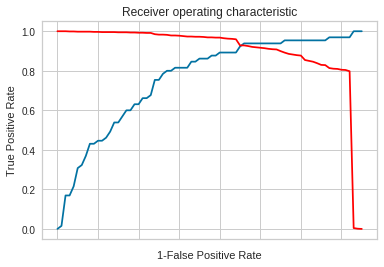

In [65]:
cut_off = bc.optimalCutoff(gbm_model[0], np.array(y_b)[test_index], 'GradientBoosting', True)

### 5.4 Confusion Matrix 
Visualize proportions of true positives, true negatives, false positives and false negatives

Confusion matrix, without normalization
[[896  38]
 [  7  58]]


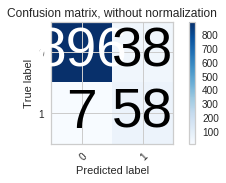

In [72]:
cut_off = 0.019589
# Apply the cut-off on the probabilities -> to assess the predictions
l_pred = [int(gbm_model[0][i] >= cut_off) for i in range(len(gbm_model[0]))]

fig = bc.plot_confusion_matrix(np.array(y_b)[test_index], l_pred, classes=['0', '1'],
                      title='Confusion matrix, without normalization')
plt.figsize=20
plt.savefig('figures/results/GBM_confusion_matrix.png', bbox_inches='tight')
plt.show(fig)

Confusion matrix, without normalization
[[798 136]
 [ 55  10]]


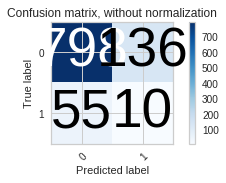

In [73]:
l_pred = fitted_wm[0]

fig = bc.plot_confusion_matrix(np.array(y_b)[test_index], l_pred, classes=['0', '1'],
                      title='Confusion matrix, without normalization')

plt.figsize=20
plt.savefig('figures/results/GBM_confusion_matrix.png', bbox_inches='tight')
plt.show(fig)

### 5.4 Calculate performance characteristics

In [74]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(np.array(y_b)[test_index], l_pred).ravel()
sensitivity,specificity = tp/(tp+fn),tn/(tn+fp)
accuracy = (tp + tn)/(tp+fn+tn+fp)
ppv,npv = tp/(tp+fp),tn/(tn+fn)
print('Sensitivity: ' + str(sensitivity), '\nSpecificity: ' + str(specificity))
print('PPV: ' +str(ppv), '\nNPV: ' + str(npv))
print('Accuracy: ' +str(accuracy))

Sensitivity: 0.15384615384615385 
Specificity: 0.854389721627409
PPV: 0.0684931506849315 
NPV: 0.9355216881594373
Accuracy: 0.8088088088088088


### 5.5 Investigate the incorrect predictions
Optional: Which cases where wrongly predicted

In [85]:
predictions = estimator.predict(X[test_index])

for inp, prediction, label in zip(X[test_index], predictions, np.array(y_b)[test_index]):
    if prediction != label:
        print('"', inp, '"\n\n', 'has been classified as ', prediction, 'and should be ', label, '\n') 
print('Cannot print example of output')

Cannot print example of output


## Step 6: Visualize most important features 
Optional Visualizations -> of best model & median Fold
### 6.1 Chi-squared test of top 20 features

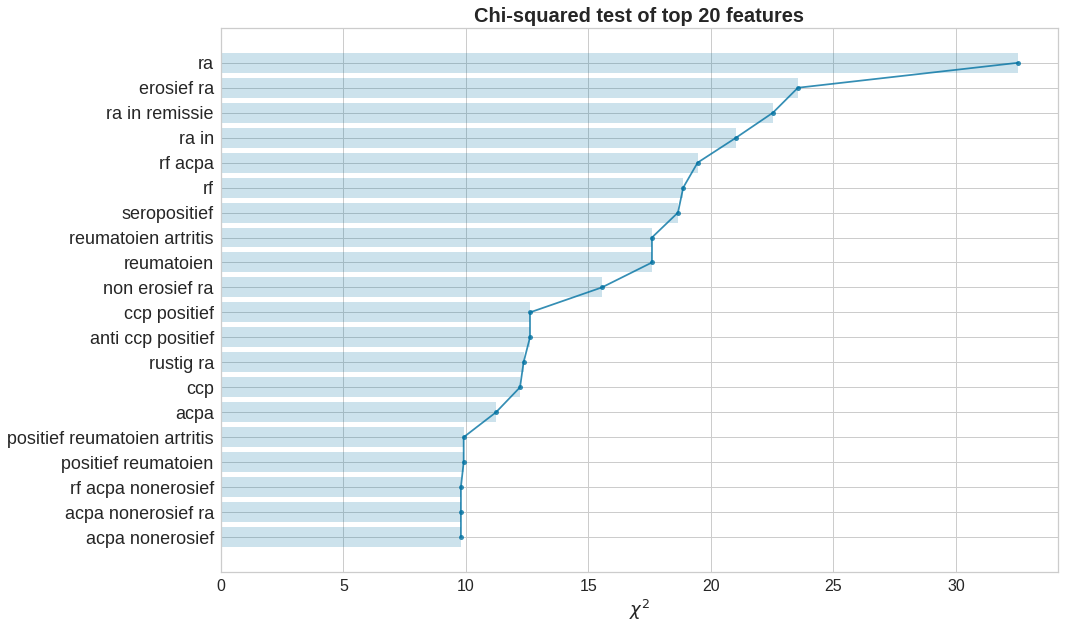

In [33]:
plt = bc.plotFeatureChiSquared(X[train_index], np.array(y)[train_index], nr_features=20, ngram_range=(1,3))

plt.show()

### 6.2 Pearson correlation per feature

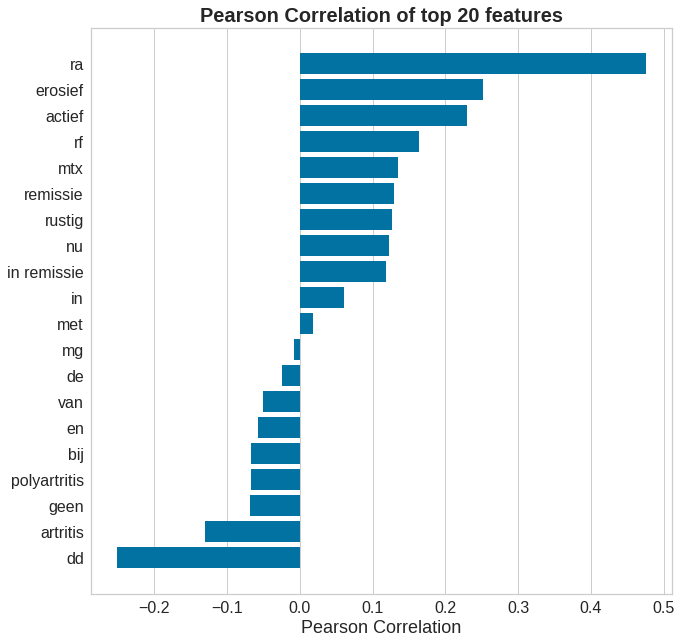

In [86]:
plt = bc.plotFeatureCorrelation(X[train_index], np.array(y_b)[train_index], nr_features=20, ngram_range=(1,3))
locs, labels = plt.yticks()  

#plt.yticks(locs, ['ra', 'erosive', 'active', 'not-active', 'on', 'rf',  'currently', 'not', 'remission', 'in', 'the', 'with', 'and', 'no', 'arthrosis', 'in case of/by', 'polyarthritis', 'of/from', 'arthritis', 'dd'][::-1])
plt.show()

### 6.3 Explained variance per feature according to the best performing model
Feature importance is calculated with the leave-one-out method to assess the explained variance of said feature. In other words: The importance of each feature reflects the model error caused by exclusion of said feature.

- The feature importance can only be calculated for decision tree like classifiers

[0.02227351 0.02241569 0.02327549 0.03160841 0.03845576 0.04592678
 0.05691936 0.09386324 0.306124   0.35913776]


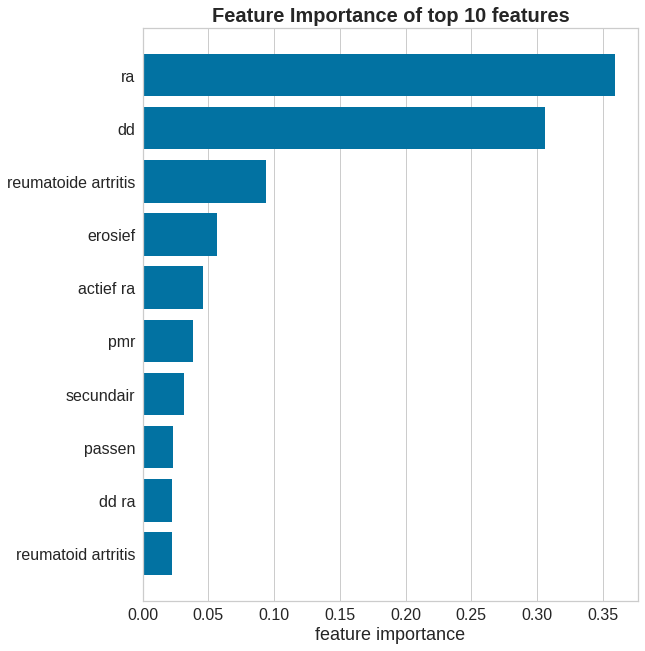

In [87]:
import importlib
importlib.reload(bc)

plt = bc.plotFeatureImportance(tuple(classifier)[1], X[train_index], np.array(y_b)[train_index], nr_features=10, ngram_range=(1,3))
locs, labels = plt.yticks()

plt.show()

### 6.4 Trainingset | Lexical Dispersion Plot 

/home/tdmaarseveen/.conda/envs/ml_env/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


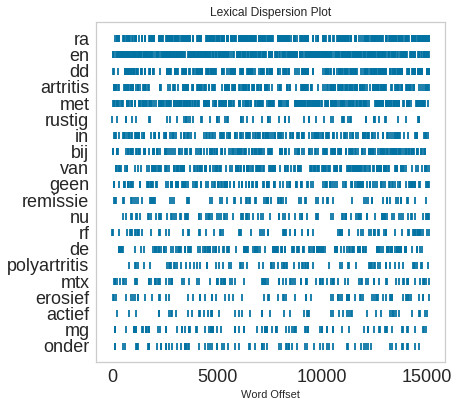

In [89]:
bc.plotLexicalDispersion(X[train_index], ngram_range = (1,1))

### 6.5 Testset | Lexical Dispersion Plot 

/home/tdmaarseveen/.conda/envs/ml_env/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


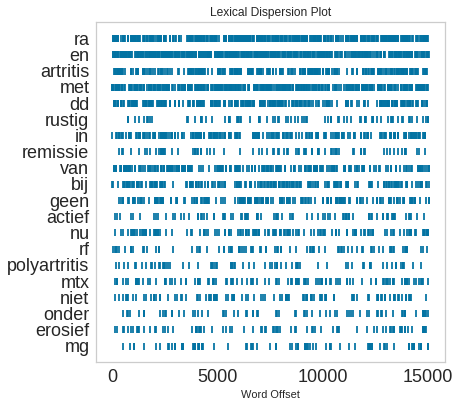

In [90]:
bc.plotLexicalDispersion(X[test_index], ngram_range = (1,1))

### 6.6 Plot distribution of n=50 prevalent features
Should be comparable -> otherwise you dont have a representable train/test set

##### Input:
- nr_features = number of features to draw in the distribution plot

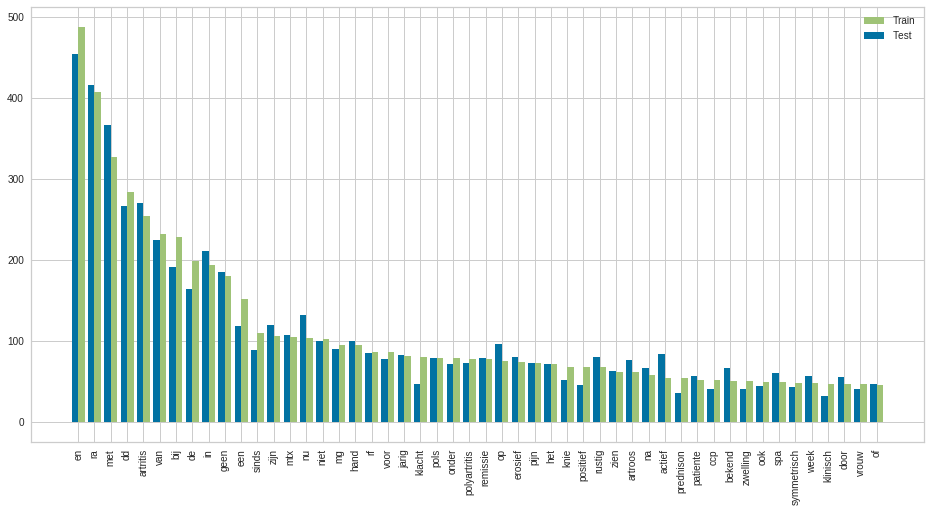

In [91]:
import matplotlib.pyplot as plt

# Assess most prevalent features
bc.plotTrainTestDistribution(X[train_index], X[test_index], nr_features=50) 

### 6.7 Graphviz | Write GBM structure to 
Outputs a file that can be visualized in http://viz-js.com/ 
##### Input:
- sub_tree = specify the subtree to draw (0-99 in this case)

In [ ]:
sub_tree = 99

test_clf = tuple(classifier)[1] # get classifier
tree2 = test_clf.estimators_[sub_tree, 0] 
lbls = tuple(estimator.steps[0])[1].get_feature_names()
bc.exportTreeGraphViz(X[train_index], tree2, lbls, 'GBM_structure_subtree' + str(sub_tree))